In [92]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.io as sio
import pprint as pp
import numpy as np
import seaborn as sns
import pandas as pd
import os
import re
import gc
# pre
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
# Study
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
import matplotlib as mpl
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D

In [2]:
MDIR = '/sanssauvegarde/homes/v18porti/info/Brest_Samples/'

In [3]:
# HELPERS
def getPatientStruct(mat_file):
    return mat_file['patient']

def getVoie(patient):
    return patient[0, 0]['voie']

# voie will have a shape of (1, n), where n # of info inside range(0,n-1)
def getVoieInfo(voie, n):
    voie_n = voie[0,n]
    return voie_n[0, 0]

def getLabels(voie, n):
    voie_n = voie[0,n]
    return (voie_n.dtype).names

def isStartStringMatched(s, m):
    return re.match(m + '.+', s)

def createDir(d):
    if not os.path.exists(d):
        os.makedirs(d)
        
def flattenList(l):
    return [item for sublist in l for item in sublist]

def flattenNPList(l):
    return l.flatten()

def getFeatureInfo(vo, n, f):
    return getVoieInfo(vo, n)[f]

In [4]:
# general info to grab for further study
# return info: labels
def getFirstOneInfo(file_path):
    mat = sio.loadmat(file_path)
    ps = getPatientStruct(mat)
    vo = getVoie(ps)
    n = (vo.shape)[1]
    labels = getLabels(vo, 0)
    del ps, vo, n, mat
    gc.collect()
    return labels
    
#labels = getFirstOneInfo(MDIR + 'RS10001/RS10001_170503_100212.mat')

In [6]:
# TEST PATIENT 1

# General variables
labels = getFirstOneInfo(MDIR + 'RS10001/RS10001_170503_100212.mat')

# Patient Variables
mat = sio.loadmat(MDIR + 'RS10001/RS10001_170503_100212.mat')
ps = getPatientStruct(mat)
vo = getVoie(ps)
n = (vo.shape)[1]

# voie variable
vectorRRKLD = getFeatureInfo(vo, 0, 'vectorRRKLD')
vectorFAmpKLD = getFeatureInfo(vo, 0, 'vectorFAmpKLD')
vectorUFAmpKLD = getFeatureInfo(vo, 0, 'vectorUFAmpKLD')
vectorCorrKLD = getFeatureInfo(vo, 0, 'vectorCorrKLD')
print(f'vectorRRKLD shape: {vectorRRKLD.shape}')
print(f'vectorFAmpKLD shape: {vectorFAmpKLD.shape}')
print(f'vectorUFAmpKLD shape: {vectorUFAmpKLD.shape}')
print(f'vectorCorrKLD shape: {vectorCorrKLD.shape}')

# Clean memory
del ps, vo, n, mat
gc.collect()

vectorRRKLD shape: (25986, 1)
vectorFAmpKLD shape: (25986, 1)
vectorUFAmpKLD shape: (25986, 1)
vectorCorrKLD shape: (25986, 1)


0

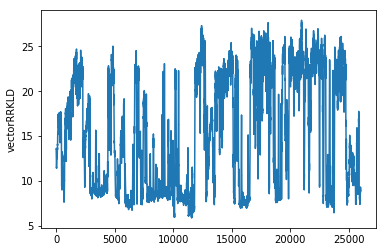

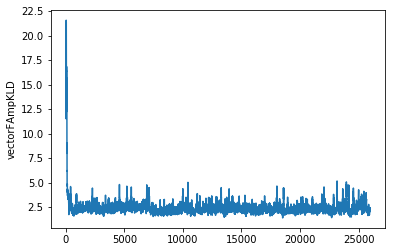

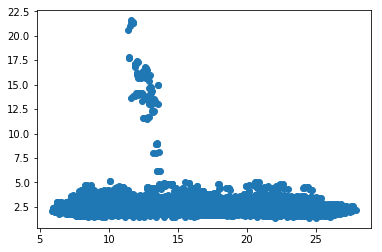

In [7]:
plt.plot(vectorRRKLD)
plt.ylabel('vectorRRKLD')
plt.show()

plt.plot(vectorFAmpKLD)
plt.ylabel('vectorFAmpKLD')
plt.show()


plt.scatter(vectorRRKLD, vectorFAmpKLD)
plt.show()

# clean memory
plt.clf()
plt.close()

In [8]:
vectorRRKLD

array([[13.593016],
       [13.593016],
       [13.570515],
       ...,
       [ 9.217281],
       [ 9.231886],
       [ 8.922528]], dtype=float32)

In [9]:
vectorRRKLD = flattenNPList(vectorRRKLD)
vectorFAmpKLD = flattenNPList(vectorFAmpKLD)
vectorUFAmpKLD = flattenNPList(vectorUFAmpKLD)
vectorCorrKLD = flattenNPList(vectorCorrKLD)

In [10]:
def putDataInDict(data, labels):
    if len(labels) != len(data): raise NameError("different sizes in labels and data")
    return { labels[i]: d for i, d in enumerate(data) }

def convertDictInDF(d):
    return pd.DataFrame(d)

df = convertDictInDF(putDataInDict(
        [vectorRRKLD, vectorFAmpKLD, vectorUFAmpKLD, vectorCorrKLD],
        ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD']
    ))

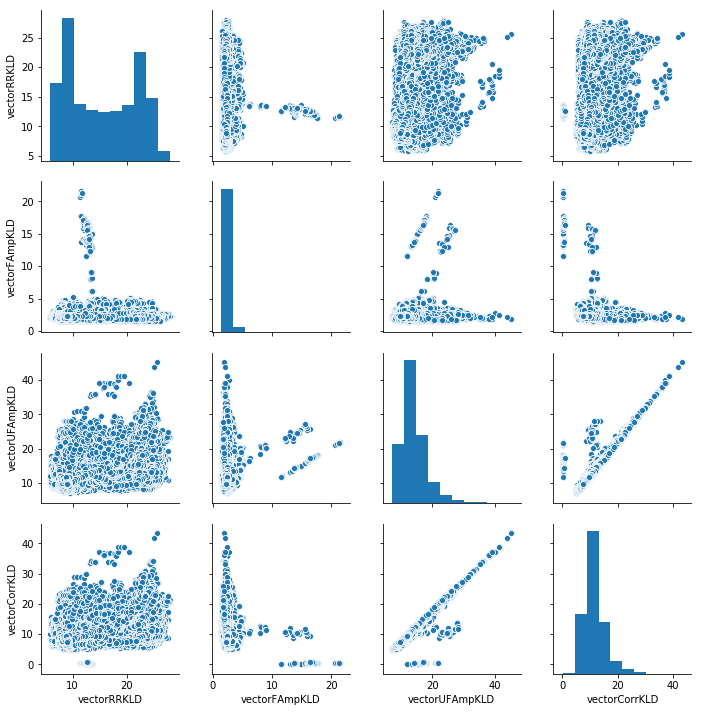

In [11]:
sns.pairplot(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25986 entries, 0 to 25985
Data columns (total 4 columns):
vectorRRKLD       25986 non-null float32
vectorFAmpKLD     25986 non-null float32
vectorUFAmpKLD    25986 non-null float32
vectorCorrKLD     25986 non-null float32
dtypes: float32(4)
memory usage: 406.1 KB


In [13]:
# Accumulate one patient info
# acumulate from same file and different structs
def getPatientVars(patient_dir):
    mat = sio.loadmat(patient_dir)
    ps = getPatientStruct(mat)
    vo = getVoie(ps)
    n = (vo.shape)[1]
    del ps, mat
    gc.collect()
    return vo, n

def addTwoNPLists(info, new_info):
    return np.concatenate((info, new_info))

def addPatientFeatureInfo(patient_dir, feature):
    info = []
    for file_path in os.listdir(patient_dir):
        if file_path.endswith(".mat"):
            vo, n = getPatientVars(patient_dir + '/' + file_path)
            for i in range(n):
                new = flattenNPList(getFeatureInfo(vo, i, feature))
                info = addTwoNPLists(info, new)       
    return info

def addAllPatientsInfo(mdir, feature):
    info = None
    for dir_path in os.listdir(mdir):
        if isStartStringMatched(dir_path, 'RS'):
            print(f'Working on {feature} - {dir_path}')
            info = addPatientFeatureInfo(mdir + dir_path, feature)
    return info

In [14]:
vectorRRKLD_ALL = addAllPatientsInfo(MDIR, 'vectorRRKLD')
vectorFAmpKLD_ALL = addAllPatientsInfo(MDIR, 'vectorFAmpKLD')
vectorUFAmpKLD_ALL = addAllPatientsInfo(MDIR, 'vectorUFAmpKLD')
vectorCorrKLD_ALL = addAllPatientsInfo(MDIR, 'vectorCorrKLD')
vectorRRKLD_ALL.shape
vectorFAmpKLD_ALL.shape
vectorUFAmpKLD_ALL.shape
vectorCorrKLD_ALL.shape

Working on vectorRRKLD - RS10000
Working on vectorRRKLD - RS10001
Working on vectorRRKLD - RS10002
Working on vectorRRKLD - RS10003
Working on vectorRRKLD - RS10004
Working on vectorRRKLD - RS10005
Working on vectorRRKLD - RS10006
Working on vectorRRKLD - RS10007
Working on vectorRRKLD - RS10008
Working on vectorRRKLD - RS10009
Working on vectorRRKLD - RS10010
Working on vectorFAmpKLD - RS10000
Working on vectorFAmpKLD - RS10001
Working on vectorFAmpKLD - RS10002
Working on vectorFAmpKLD - RS10003
Working on vectorFAmpKLD - RS10004
Working on vectorFAmpKLD - RS10005
Working on vectorFAmpKLD - RS10006
Working on vectorFAmpKLD - RS10007
Working on vectorFAmpKLD - RS10008
Working on vectorFAmpKLD - RS10009
Working on vectorFAmpKLD - RS10010
Working on vectorUFAmpKLD - RS10000
Working on vectorUFAmpKLD - RS10001
Working on vectorUFAmpKLD - RS10002
Working on vectorUFAmpKLD - RS10003
Working on vectorUFAmpKLD - RS10004
Working on vectorUFAmpKLD - RS10005
Working on vectorUFAmpKLD - RS10006


(227035,)

In [15]:
df_ALL = convertDictInDF(putDataInDict(
        [vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL],
        ['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL']
    ))

In [16]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227035 entries, 0 to 227034
Data columns (total 4 columns):
vectorRRKLD_ALL       227029 non-null float64
vectorFAmpKLD_ALL     227035 non-null float64
vectorUFAmpKLD_ALL    227035 non-null float64
vectorCorrKLD_ALL     227035 non-null float64
dtypes: float64(4)
memory usage: 6.9 MB


In [17]:
df_ALL.head()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
0,15.404995,9.761175,9.926565,0.165390
1,15.278440,9.631824,9.733707,0.101884
2,15.160186,9.450975,9.552859,0.101884
3,15.024813,9.462391,9.564275,0.101884
4,14.859758,9.456635,9.558518,0.101884


/homes/v18porti/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/homes/v18porti/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


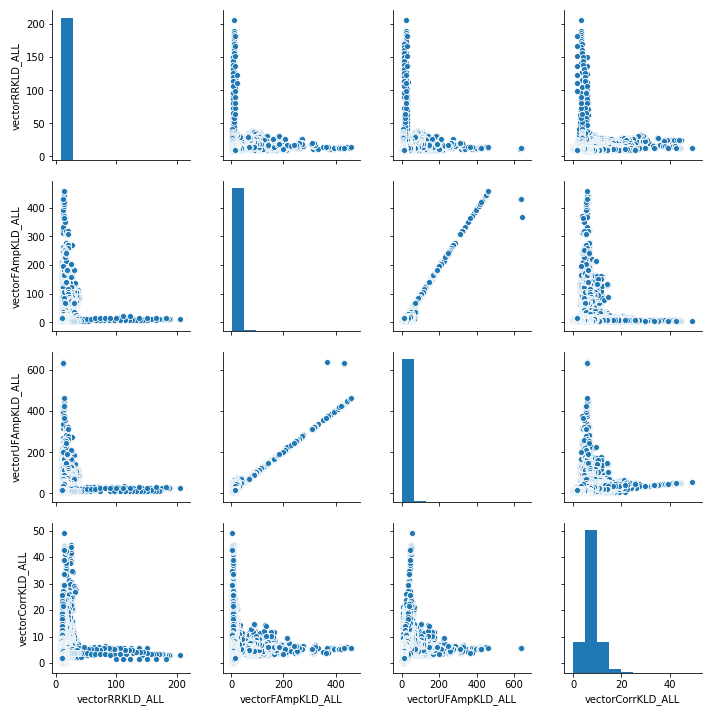

In [18]:
sns.pairplot(df_ALL)

In [19]:
df_ALL.describe()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
count,227029.000000,227035.000000,227035.000000,227035.000000
mean,12.473469,9.354833,18.456393,7.463934
std,3.292251,14.124923,15.299198,2.910295
min,8.741988,2.739244,4.854638,0.000764
25%,10.527782,6.022472,12.564055,5.578577
50%,11.696346,7.297211,14.917339,7.000749
75%,13.697694,9.240294,19.237986,8.925457
max,205.866913,458.070251,640.493042,49.242596


In [20]:
def draw_correlation_matrix(df):
    sns.set(style="white")
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 5))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #color_palette("GnBu_d")
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5})

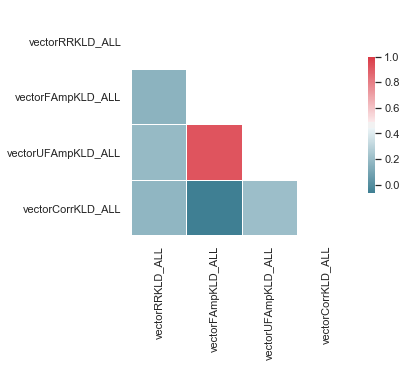

In [21]:
draw_correlation_matrix(df_ALL)

In [22]:
corrm = df_ALL.corr()
#corrm["vectorFAmpKLD_ALL"].sort_values(ascending=False)
corrm

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
vectorRRKLD_ALL,1.000000,0.163057,0.193009,0.178031
vectorFAmpKLD_ALL,0.163057,1.000000,0.922950,-0.062243
vectorUFAmpKLD_ALL,0.193009,0.922950,1.000000,0.208356
vectorCorrKLD_ALL,0.178031,-0.062243,0.208356,1.000000


In [23]:
df_ALL.shape

(227035, 4)

In [24]:
# There is nothing in Scikit-Learn to handle Pandas DataFrames
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [25]:
# are there some nan values? 
len(df_ALL) - df_ALL.count() # same as: df_ALL.isnull().sum()

vectorRRKLD_ALL       6
vectorFAmpKLD_ALL     0
vectorUFAmpKLD_ALL    0
vectorCorrKLD_ALL     0
dtype: int64

In [26]:
num_attribs = list(df_ALL)
pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])
print(num_attribs)
print(pipeline)

['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL']
Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])


In [27]:
full_pipeline = FeatureUnion(transformer_list=[
    ("main", pipeline),
    ])
data_prepared = full_pipeline.fit_transform(df_ALL)
print(data_prepared.shape)
data_prepared

(227035, 4)


array([[ 0.89045148,  0.02876777, -0.5575355 , -2.50784211],
       [ 0.85201052,  0.01961007, -0.57014127, -2.52966344],
       [ 0.81609119,  0.00680656, -0.58196205, -2.52966344],
       ...,
       [-0.71286391,  0.31749935, -0.18550248, -1.95343243],
       [-0.71330509,  0.31636074, -0.1843519 , -1.94185782],
       [-0.72552336,  0.30528655, -0.19406408, -1.93916629]])

In [28]:
df_normalized = convertDictInDF(putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD_N', 'vectorFAmpKLD_N', 'vectorUFAmpKLD_N', 'vectorCorrKLD_N']
    ))
df_normalized.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,2.270350e+05,2.270350e+05,2.270350e+05,2.270350e+05
mean,-2.323461e-16,-1.226827e-17,6.008950e-17,3.204774e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.133423e+00,-4.683639e-01,-8.890521e-01,-2.564409e+00
25%,-5.909835e-01,-2.359212e-01,-3.851411e-01,-6.478248e-01
50%,-2.360431e-01,-1.456735e-01,-2.313233e-01,-1.591543e-01
75%,3.718563e-01,-8.109020e-03,5.108730e-02,5.021920e-01
max,5.874288e+01,3.176771e+01,4.065821e+01,1.435551e+01


In [29]:
X = data_prepared

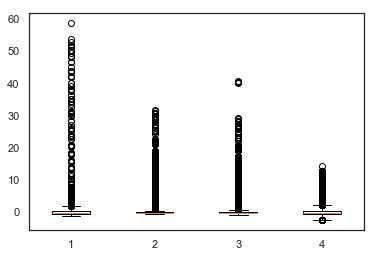

In [87]:
plt.boxplot(data_prepared)
plt.show()
plt.close()

## PCA
** [0.50219192 0.28210948 0.20605092 0.00964767] : first 3 carries the most info with standarized data **
<br>
** [0.92169138 0.04827627 0.02278563 0.00724673] : first 1 carries the most info without standarizing data **

In [30]:
pca = PCA(n_components=3)
pca.fit(X)  
# [0.50219192 0.28210948 0.20605092 0.00964767] : first 3 carries the most info with standarized data
# [0.92169138 0.04827627 0.02278563 0.00724673] : first 1 carries the most info without standarizing data
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)
print(pca.components_)

[0.50219192 0.28210948 0.20605092]
[675.32256862 506.15699797 432.5772608 ]
[[ 0.2642539   0.66144469  0.68621232  0.1475583 ]
 [ 0.55349939 -0.30205909 -0.08781538  0.77115964]
 [ 0.7897125   0.00145624 -0.17936112 -0.58666995]]


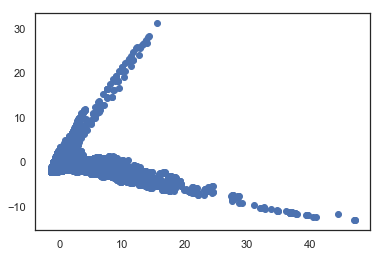

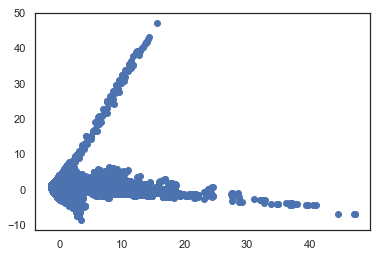

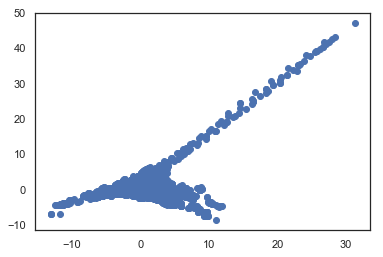

In [31]:
X_New = pca.transform(X)
principalDf = pd.DataFrame(data=X_New, columns=['pc1', 'pc2', 'pc3'])

# in 3D
"""
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalDf['pc1'], principalDf['pc2'])
"""
# in 2D
%matplotlib inline
"""fig, axs = plt.subplots(1, 2)
axs[0].scatter(principalDf['pc1'], principalDf['pc2'])
axs[1].scatter(df_ALL['vectorRRKLD_ALL'], df_ALL['vectorFAmpKLD_ALL'])
plt.show()
fig.clf()
plt.close()"""

plt.scatter(principalDf['pc1'], principalDf['pc2'])
plt.show()
plt.clf()
plt.close()

plt.scatter(principalDf['pc1'], principalDf['pc3'])
plt.show()
plt.clf()
plt.close()

plt.scatter(principalDf['pc2'], principalDf['pc3'])
plt.show()
plt.clf()
plt.close()

In [56]:
principalDf.describe()

,pc1,pc2,pc3
count,2.270350e+05,2.270350e+05,2.270350e+05
mean,-2.804177e-17,3.204774e-17,2.403580e-17
std,1.417313e+00,1.062282e+00,9.078586e-01
min,-1.359453e+00,-1.313083e+01,-8.773150e+00
25%,-5.687907e-01,-6.443638e-01,-4.092581e-01
50%,-2.455132e-01,-1.372101e-01,-2.486826e-02
75%,2.129901e-01,5.606458e-01,3.836620e-01
max,4.723246e+01,3.130395e+01,4.717505e+01


In [64]:
titles = principalDf.columns.tolist()

## 1 Gaussian Mixture Model
https://scikit-learn.org/stable/unsupervised_learning.html

In [32]:
X = X_New
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

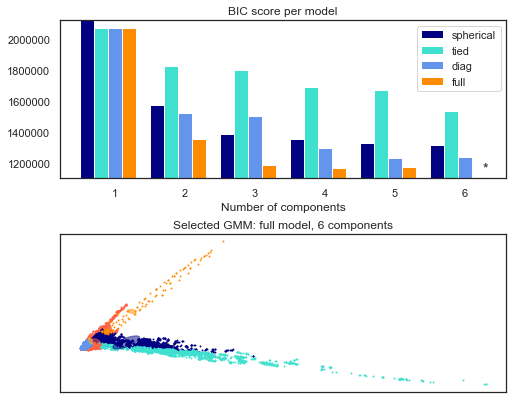

In [33]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'gold', 'tomato'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
cnt = 0
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)
    cnt += 1

plt.xticks(())
plt.yticks(())
plt.title(f'Selected GMM: full model, {cnt} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()
plt.clf()
plt.close()

** *Even if the BIC tells us that there should be 5 components, it seems though that it could be smaller **

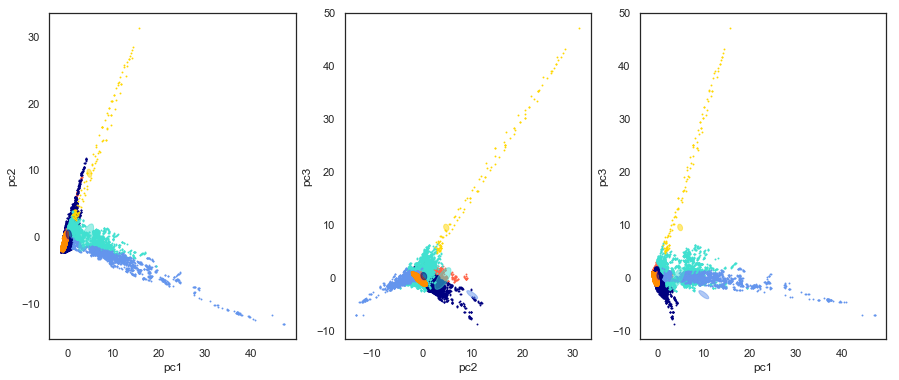

In [66]:
def getPlotGMM(gmm, X, color_iter, col1, col2, ax, sb, tts, show_gc=True):
    Y_ = gmm.predict(X)
    for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_,
                                           color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, col1], X[Y_ == i, col2], .8, color=color)
        ax.set_xlabel(titles[col1])
        ax.set_ylabel(titles[col2])

        if not show_gc: continue
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(.5)
        ax.add_artist(ell)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
getPlotGMM(best_gmm, X, color_iter, 0, 1, ax[0], titles, fig)
getPlotGMM(best_gmm, X, color_iter, 1, 2, ax[1], titles, fig)
getPlotGMM(best_gmm, X, color_iter, 0, 2, ax[2], titles, fig)
plt.show()
fig.clf()
plt.close()


## 2 K-Means

In [35]:
X = X_New
km = KMeans(n_clusters=3, random_state=1).fit(X)

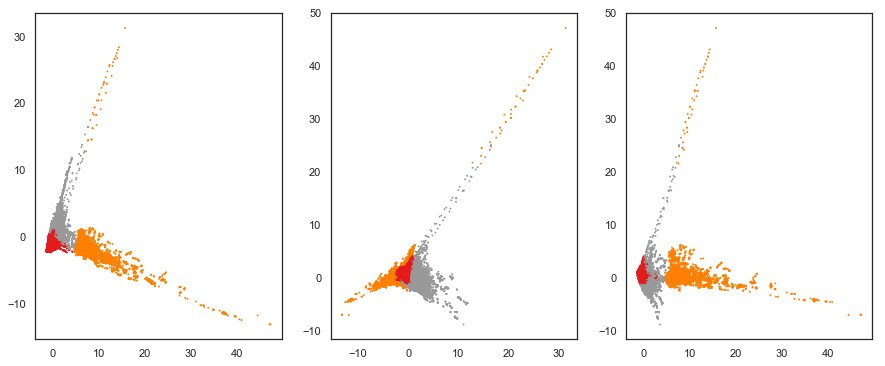

In [46]:
Y_ = km.predict(X)
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=Y_, s=0.8, cmap='Set1')
ax[1].scatter(X[:, 1], X[:, 2], c=Y_, s=0.8, cmap='Set1')
ax[2].scatter(X[:, 0], X[:, 2], c=Y_, s=0.8, cmap='Set1')
plt.show()
plt.close()

In [70]:
def getKmeanskClusters(k, X):
    km = KMeans(n_clusters=k, random_state=1).fit(X)
    Y_ = km.predict(X)
    return Y_

def printThreeKMaeans(X, Y_, titles):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].scatter(X[:, 0], X[:, 1], c=Y_, s=0.8, cmap='Set1')
    ax[0].set_xlabel(titles[0])
    ax[0].set_ylabel(titles[1])
    ax[1].scatter(X[:, 1], X[:, 2], c=Y_, s=0.8, cmap='Set1')
    ax[1].set_xlabel(titles[1])
    ax[1].set_ylabel(titles[2])
    ax[2].scatter(X[:, 0], X[:, 2], c=Y_, s=0.8, cmap='Set1')
    ax[2].set_xlabel(titles[0])
    ax[2].set_ylabel(titles[2])
    plt.show()
    plt.close()

In [ ]:
X = X_New
Y_ = getKmeanskClusters(2, X)
printThreeKMaeans(X, Y_, titles)

In [52]:
Y_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

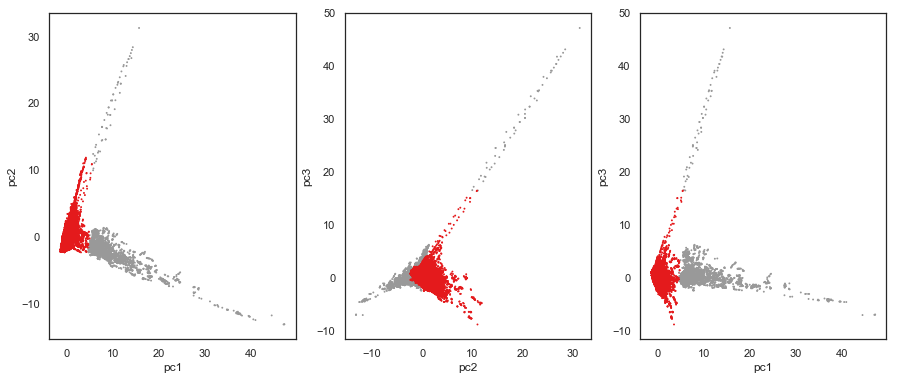

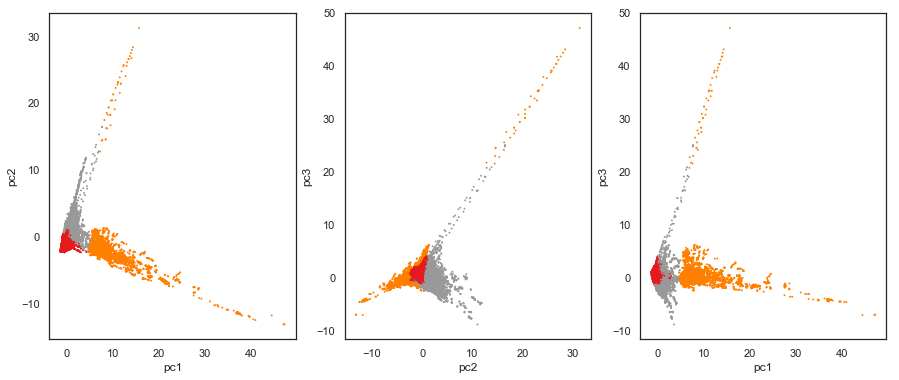

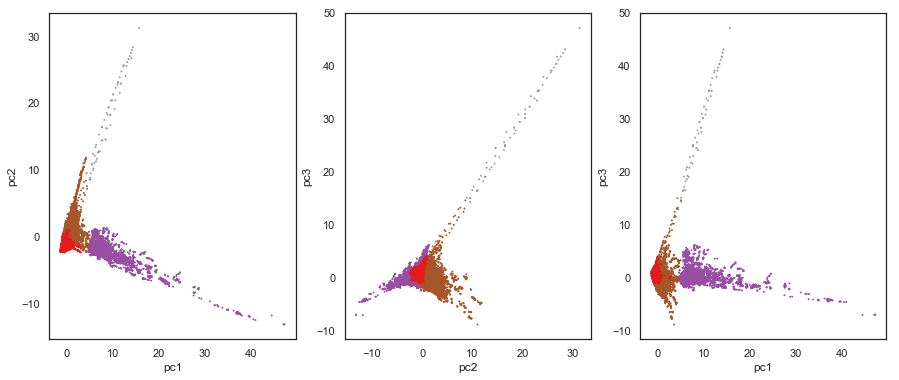

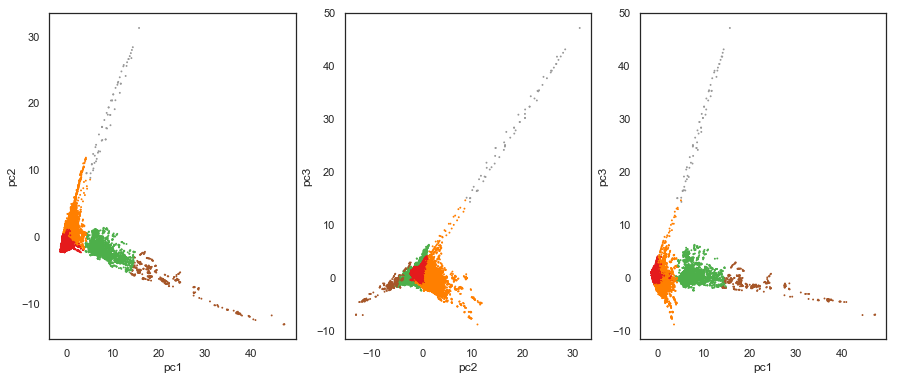

In [71]:
X = X_New
Y_ = getKmeanskClusters(2, X)
printThreeKMaeans(X, Y_, titles)
X = X_New
Y_ = getKmeanskClusters(3, X)
printThreeKMaeans(X, Y_, titles)
X = X_New
Y_ = getKmeanskClusters(4, X)
printThreeKMaeans(X, Y_, titles)
X = X_New
Y_ = getKmeanskClusters(5, X)
printThreeKMaeans(X, Y_, titles)

## 3 Mean Shift
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [94]:
X
bandwidth = estimate_bandwidth(X, n_samples=500)

In [95]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 71
